In [2]:

import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import seaborn as sns 
import datetime as dt
from collections import Counter
from nltk.tokenize import sent_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score


from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [3]:
df = pd.read_csv(r'/content/drive/MyDrive/Projects/Twitter_Sentiment_Analysis_US_Presedential_Elction2020/Data/Trump_No_Retweet_Full_Text.csv',error_bad_lines=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
df.head(5)

,Date,Tweet_id,Verified,Tweet,User,Location,Source,Likes,Followers,Following,Retweets
0,2020-07-21 23:59:54,1285726226813014016,False,"You are amazing, @chicagosmayor. I hope you g...",rathacat,"Patterson, CA",Twitter Web App,1,2429,3710,0
1,2020-07-21 23:59:51,1285726213001093127,False,#Trump finally admitted that the spread of the...,Nor_Kan_1965,NaN,Twitter for Android,1,112,73,1
2,2020-07-21 23:59:30,1285726126820794368,False,@NavygirlLaura @GOP A sure sign the #GOP party...,ShannsolSolberg,"Texas, USA",Twitter for iPhone,1,1359,1745,0
3,2020-07-21 23:59:20,1285726083455877121,False,Why is #Trump silent when cops beat a #Veteran...,in_pubs,NJ-DC-NY-🌍,Twitter for iPhone,650,78851,17726,254
4,2020-07-21 23:58:51,1285725963024818183,False,"@gtconway3d Speaking of falling, please be car...",dfwcitizen,• GOD BLESS AMERICA •,Twitter for iPhone,2,5333,375,0


In [5]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15725 entries, 0 to 15724
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       15725 non-null  object
 1   Tweet_id   15725 non-null  int64 
 2   Verified   15725 non-null  bool  
 3   Tweet      15725 non-null  object
 4   User       15725 non-null  object
 5   Location   11416 non-null  object
 6   Source     15725 non-null  object
 7   Likes      15725 non-null  int64 
 8   Followers  15725 non-null  int64 
 9   Following  15725 non-null  int64 
 10  Retweets   15725 non-null  int64 
dtypes: bool(1), int64(5), object(5)
memory usage: 1.2+ MB


In [6]:
df.shape

(15725, 11)

# Data Preprocessing and cleaning

The Date column is an object type. Let us convert it to datetime using datetime module.

In [7]:
df['Date'] = df['Date'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S')) #Convert to date time format

In [9]:

df.dtypes

Date         datetime64[ns]
Tweet_id              int64
Verified               bool
Tweet                object
User                 object
Location             object
Source               object
Likes                 int64
Followers             int64
Following             int64
Retweets              int64
dtype: object

Let us check for any null value in the dataset

In [10]:
df.isnull().sum()

Date            0
Tweet_id        0
Verified        0
Tweet           0
User            0
Location     4309
Source          0
Likes           0
Followers       0
Following       0
Retweets        0
dtype: int64

The location column has upto 13238 values as null. This may be the case since many users didn't voluntarily put it up. However this is not of much concern for our project. Hence we would leave it to null only

In [11]:
df['Source'].value_counts()

Twitter Web App               5815
Twitter for iPhone            4382
Twitter for Android           3274
Twitter for iPad               751
TweetDeck                      249
                              ... 
An-Nahar Tweeter                 1
Tweetbot for Mac                 1
Donald Trump News App            1
Archive Google Spreadsheet       1
pfff_shop                        1
Name: Source, Length: 138, dtype: int64

In [12]:
df['Location'].nunique()

3321

In [13]:

tweets_list = df['Tweet'].tolist()
len(tweets_list)

15725

In [14]:
tweets_list_updated = set(tweets_list)
len(tweets_list_updated)

15654

In [15]:
tweets_list_updated  = list(tweets_list_updated)
type(tweets_list_updated)


list

In [16]:
df['Tweet'].duplicated().sum()


71

In [17]:

df = df.drop_duplicates(subset = 'Tweet', keep = 'first',ignore_index = True)
df.shape

(15654, 11)

In [18]:
df['Tweet'].duplicated().sum()

0

# Removing emojis

In [19]:
def remove_emoji(tweet):
    emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', tweet)



df['Processed_Tweet']=df.Tweet.apply(remove_emoji)


In [20]:

count = 0
for i in df['Processed_Tweet']:
    if re.match(r'^RT', i):  #remove any rows that contain RT
        df.drop(df.loc[df['Processed_Tweet']==i].index,inplace = True)
        count+=1
    
count

0

In [21]:

df.shape

(15654, 12)

In [22]:
df['Processed_Tweet']

0        You are amazing, @chicagosmayor.  I hope you g...
1        #Trump finally admitted that the spread of the...
2        @NavygirlLaura @GOP A sure sign the #GOP party...
3        Why is #Trump silent when cops beat a #Veteran...
4        @gtconway3d Speaking of falling, please be car...
                               ...                        
15649    "It’s far easier to remain in self-delusion an...
15650    If you actually thought that #Trump had undama...
15651    Attempted assassination (son killed) of NJ #Ob...
15652    Losing respect for #FoxNews people like #Chris...
15653    @johnlewis we are to fly our flag half staff ?...
Name: Processed_Tweet, Length: 15654, dtype: object


# Remove Retweets

In [23]:
df['Processed_Tweet'] = [re.sub('^RT[\s]','',i) for i in df['Processed_Tweet']]  #Remove RT substring

In [24]:
df['Processed_Tweet']

0        You are amazing, @chicagosmayor.  I hope you g...
1        #Trump finally admitted that the spread of the...
2        @NavygirlLaura @GOP A sure sign the #GOP party...
3        Why is #Trump silent when cops beat a #Veteran...
4        @gtconway3d Speaking of falling, please be car...
                               ...                        
15649    "It’s far easier to remain in self-delusion an...
15650    If you actually thought that #Trump had undama...
15651    Attempted assassination (son killed) of NJ #Ob...
15652    Losing respect for #FoxNews people like #Chris...
15653    @johnlewis we are to fly our flag half staff ?...
Name: Processed_Tweet, Length: 15654, dtype: object


# Remove Usernames

In [25]:
df['Processed_Tweet'] = [re.sub('@[^\s]+', ' ', i) for i in df['Processed_Tweet']] #remove usernames

In [26]:

df['Processed_Tweet']

0        You are amazing,    I hope you get all the sup...
1        #Trump finally admitted that the spread of the...
2            A sure sign the #GOP party is breaking apa...
3        Why is #Trump silent when cops beat a #Veteran...
4          Speaking of falling, please be careful climb...
                               ...                        
15649    "It’s far easier to remain in self-delusion an...
15650    If you actually thought that #Trump had undama...
15651    Attempted assassination (son killed) of NJ #Ob...
15652    Losing respect for #FoxNews people like #Chris...
15653      we are to fly our flag half staff ? dont thi...
Name: Processed_Tweet, Length: 15654, dtype: object

In [27]:
df['Processed_Tweet'] = [re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', i) for i in df['Processed_Tweet']] #Remove urls

In [28]:
df['Processed_Tweet'] = [re.sub(r'#([^\s]+)', r'\1', i) for i in df['Processed_Tweet']] # remove the # in #hashtag

In [29]:
!pip install tweet-preprocessor


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
import preprocessor.api as p
df['Processed_Tweet'] = [p.clean(i) for i in df['Processed_Tweet']]

In [31]:

df['Processed_Tweet']

0        You are amazing, I hope you get all the suppor...
1        Trump finally admitted that the spread of the ...
2        A sure sign the GOP party is breaking apart is...
3        Why is Trump silent when cops beat a Veteran a...
4        Speaking of falling, please be careful climbin...
                               ...                        
15649    "Its far easier to remain in self-delusion and...
15650    If you actually thought that Trump had undamag...
15651    Attempted assassination (son killed) of NJ Oba...
15652    Losing respect for FoxNews people like ChrisWa...
15653    we are to fly our flag half staff ? dont think...
Name: Processed_Tweet, Length: 15654, dtype: object


# Removing Any Special Characters, Numbers, Punctuations etc.

In [32]:
#removing unnecessary special characters, numbers, punctuations in tweets
df.Processed_Tweet = df.Processed_Tweet.str.replace("[^a-zA-Z]", " ")
df.Processed_Tweet = [low.lower() for low in df.Processed_Tweet] #Converting into lower case
df.Processed_Tweet =  df.Processed_Tweet.str.replace("amp", "")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [33]:
df['Processed_Tweet'][40] #Sample tweet

'it wasnt just hitlerit isnt just trumpboth these men were enabled by their societies  the chilling reality '

In [34]:
df.Processed_Tweet = [low.lower() for low in df.Processed_Tweet] #Converting into lower case 

In [35]:
df["Processed_Tweet"]

0        you are amazing  i hope you get all the suppor...
1        trump finally admitted that the spread of the ...
2        a sure sign the gop party is breaking apart is...
3        why is trump silent when cops beat a veteran a...
4        speaking of falling  please be careful climbin...
                               ...                        
15649     its far easier to remain in self delusion and...
15650    if you actually thought that trump had undamag...
15651    attempted assassination  son killed  of nj oba...
15652    losing respect for foxnews people like chriswa...
15653    we are to fly our flag half staff   dont think...
Name: Processed_Tweet, Length: 15654, dtype: object

In [36]:
df.Processed_Tweet =  df.Processed_Tweet.str.replace("amp", "")

In [38]:
df['Processed_Tweet'][1] #Sample tweet

'trump finally admitted that the spread of the coronavirus  will get worse  before it gets better  you re too late joining the party  all the snacks are gone  you were supposed to be here months ago unfittobepresident coronavirus'


# EDA

In [39]:
df['User'].value_counts()

FOREXEAASSARV10    238
Hotpage_News       101
robinsnewswire      86
JonUPS_             73
POTUSNetwork        65
                  ... 
AreMeatballs         1
DrBurkl              1
BridgetWesson        1
randee55             1
onemorevoice7        1
Name: User, Length: 8110, dtype: int64

In [40]:
df.query('User == "FOREXEAASSARV10"').Processed_Tweet.tolist()

['ex laguna beach officer held gun to colleague s head after bar hopping  prosecutors say click the link plandemic news trump nwo wakeup covid   covidiots covid   coronavirus breakingnews breaking',
 'pilot truck stop empire moves away from family leadership click the link plandemic news trump nwo wakeup covid   covidiots covid   coronavirus breakingnews breaking',
 'nasdaq takes a turn to new session lows click the link plandemic news trump nwo wakeup covid   covidiots covid   coronavirus breakingnews breaking',
 'little noticed  filipino americans are dying of covid    at an alarming rate click the link plandemic news trump nwo wakeup covid   covidiots covid   coronavirus breakingnews breaking',
 'apple pledges to be carbon neutral by click the link plandemic news trump nwo wakeup covid   covidiots covid   coronavirus breakingnews breaking',
 'eur gbp price forecast  eurgbp tests key psychological level click the link plandemic news trump nwo wakeup covid   covidiots covid   coronavi

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


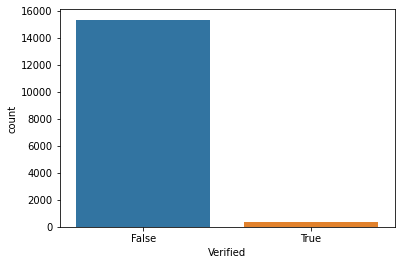

In [41]:
bar = sns.countplot(df['Verified'])

In [42]:
df['Verified'].value_counts()

False    15328
True       326
Name: Verified, dtype: int64

In [43]:
df_verified = df.query('Verified == True')

In [44]:

df_verified['User'].value_counts()

alana_austin       27
DeeTwoCents        19
AndyOstroy         16
Cairo67Unedited    14
suzannelynch1      10
                   ..
TedRubin            1
usatodayopinion     1
michelechollow      1
EdtheSock           1
OSHAReporter        1
Name: User, Length: 153, dtype: int64

In [45]:

df_verified.query('User == "Cairo67Unedited"').Processed_Tweet.tolist()

['well that didn t take long press conference where trump said maskupwas minutes ago new scandal trumps request of an ambassador  get the british open for me',
 'trump says   virus will get worse before it gets better now more than u s  military members have contracted the virus  and the infection rate in the armed services has tripled over the past six weeks ',
 'ignorance can kill and trump politicized this pandemicthe result today there is an r next to of top statesr florida d california r texas r arizona    r georgia r tennessee     r south carolina     r oklahoma     r louisiana     r mississippi     ',
 'someone in trump  s inner circle got to trump  convinced  if you don t change the narrative on covid   you will definitely lose in november i suspected it when he announced the presser today and after this show it is a certaintyhe said  it will get worse before it gets better ',
 'trump comm director tim murtaugh thought  incorrectly  he could bully the brilliant with one lying t

In [46]:
df_verified.query('User == "AndyOstroy"').Processed_Tweet.tolist()

['to everyone wanking off right now to trump s big  pivot  today of  embracing  masks and distancing   please don t make me rub it in your face tomorrow when he returns to being a mask mocking sociopath    covid   coronavirus',
 'republicans  definition of trump derangement syndrome january   he s living rent free in libtards  heads  now   good lord   he s gonna cost us the white house and the senate    ',
 'this might be a tad psychological  but if we re ever to truly understand trump s deranged pathology we ll need to understand why he wishes unconscionably corrupt evil people like ghislainemaxwell  well    ',
 'so  in stunningly meaningless minutes from we learn that covid   s gonna get worse before it gets better    and that he carries a mask in his pocket  do coronavirus droplets spread through cheap  s suits  trump',
 ' trump just said twice about global child sex trafficker ghislainemaxwell   i wish her well    ',
 'wrote this years ago  not such a stretch now  is it     trump c

In [47]:
days = df['Date'].dt.day.tolist()

In [48]:
no_of_days = Counter(days)
no_of_days

Counter({21: 10145, 20: 5509})

Text(0.5, 1.0, 'Count Of Extracted Tweets On Each Day')

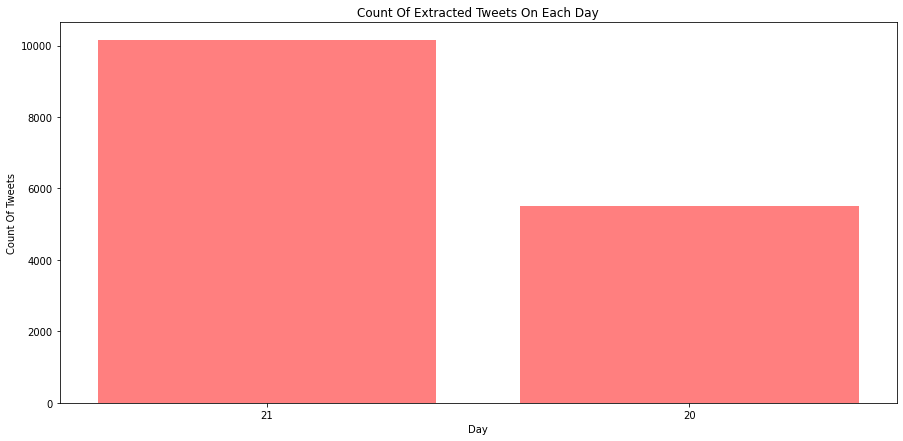

In [49]:
fig = plt.figure(figsize = (15,7))
plt.bar(range(len(no_of_days)), list(no_of_days.values()), align='center', alpha = 0.5,color = 'red')
plt.xticks(range(len(no_of_days)), list(no_of_days.keys()))
plt.xlabel("Day")
plt.ylabel("Count Of Tweets")
plt.title("Count Of Extracted Tweets On Each Day")

In [50]:
hours = df['Date'].dt.hour.tolist()

In [51]:

no_of_hours = Counter(hours)
no_of_hours

Counter({23: 1127,
         22: 1337,
         21: 1633,
         20: 1076,
         19: 993,
         18: 932,
         17: 1039,
         16: 948,
         15: 951,
         14: 948,
         13: 814,
         12: 447,
         11: 321,
         10: 216,
         9: 176,
         8: 168,
         7: 175,
         6: 206,
         5: 233,
         4: 295,
         3: 352,
         2: 408,
         1: 449,
         0: 410})

Text(0.5, 1.0, 'Count Of Extracted Tweets On Each Hour')

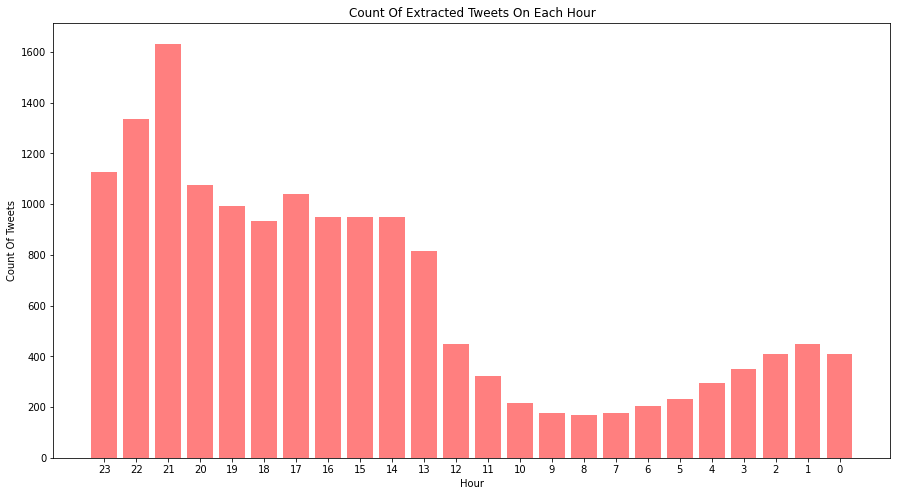

In [52]:
fig = plt.figure(figsize = (15,8))
plt.bar(range(len(no_of_hours)), list(no_of_hours.values()), align='center', alpha = 0.5,color = 'red')
plt.xticks(range(len(no_of_hours)), list(no_of_hours.keys()))
plt.xlabel("Hour")
plt.ylabel("Count Of Tweets")
plt.title("Count Of Extracted Tweets On Each Hour")

In [53]:
from wordcloud import WordCloud
tokenizer = TweetTokenizer()

In [54]:
import nltk
nltk.download('stopwords')
from nltk.corpus import words
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) 
stop_words = list(stop_words)
print(stop_words) #remove stop words

['most', 'in', 'whom', 'him', 'into', 'which', "that'll", 'or', 'than', "didn't", 'those', 'while', 'm', 'me', 'by', 'yourself', 'there', 'herself', 'between', "shouldn't", 'for', 'they', 'to', "isn't", 'their', 'same', 'over', 'being', 'having', 'wasn', 'i', 'can', 'ma', 'be', 'of', 'these', 'ours', 's', 'his', 'its', 'any', 'won', 'them', 'why', 'her', 'it', 'hers', "she's", 'here', 'but', 'out', 'weren', 'if', 'then', 't', 'before', 'down', 'how', 'during', 'yourselves', "wouldn't", 'as', 'about', 'so', 'd', "hasn't", 'we', 'now', 'hadn', 'y', 'not', 'needn', 'ourselves', 'on', 'under', "haven't", 'each', 'from', 'after', "mightn't", "you're", 'should', 'that', 'no', 'this', "you'll", "you'd", 'few', 'where', "shan't", 'she', 'o', 'does', 'my', 'shan', 'mustn', 'are', 'he', "wasn't", 'own', 'off', 'at', 'don', 'was', "aren't", 'is', 'too', 'do', 've', 'what', 'had', 'below', 'theirs', 'until', "needn't", "won't", 'further', 'myself', 'an', 'a', 'more', 'the', 'isn', 'couldn', "don't

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [55]:
df['Processed_Tweet'] = df.Processed_Tweet.apply(lambda x: ' '.join(w for w in x.split() if w not in stop_words))   #Remove stopwords




In [56]:
df['Processed_Tweet'] = df['Processed_Tweet'].apply(lambda x: tokenizer.tokenize(x)) #tokenize

In [57]:
#Perform stemming 
def lemmatize_stemming(text):
    stemmer=PorterStemmer()
    return stemmer.stem(text)

In [58]:
df['Processed_Tweet'] = df['Processed_Tweet'].apply(lambda x: [lemmatize_stemming(i) for i in x]) # stemming

In [59]:
df['Processed_Tweet']

0        [amaz, hope, get, support, need, resist, trump...
1        [trump, final, admit, spread, coronaviru, get,...
2        [sure, sign, gop, parti, break, apart, start, ...
3        [trump, silent, cop, beat, veteran, put, hospi...
4        [speak, fall, pleas, care, climb, chairthos, p...
                               ...                        
15649    [far, easier, remain, self, delus, seek, delud...
15650    [actual, thought, trump, undamag, brain, cell,...
15651    [attempt, assassin, son, kill, nj, obama, nomi...
15652    [lose, respect, foxnew, peopl, like, chriswall...
15653    [fli, flag, half, staff, dont, think, racist, ...
Name: Processed_Tweet, Length: 15654, dtype: object

In [60]:
df['Processed_Tweet'] = df.Processed_Tweet.apply(lambda x: [i for i in x if len(i)>2])

In [61]:
df

,Date,Tweet_id,Verified,Tweet,User,Location,Source,Likes,Followers,Following,Retweets,Processed_Tweet
0,2020-07-21 23:59:54,1285726226813014016,False,"You are amazing, @chicagosmayor. I hope you g...",rathacat,"Patterson, CA",Twitter Web App,1,2429,3710,0,"[amaz, hope, get, support, need, resist, trump..."
1,2020-07-21 23:59:51,1285726213001093127,False,#Trump finally admitted that the spread of the...,Nor_Kan_1965,NaN,Twitter for Android,1,112,73,1,"[trump, final, admit, spread, coronaviru, get,..."
2,2020-07-21 23:59:30,1285726126820794368,False,@NavygirlLaura @GOP A sure sign the #GOP party...,ShannsolSolberg,"Texas, USA",Twitter for iPhone,1,1359,1745,0,"[sure, sign, gop, parti, break, apart, start, ..."
3,2020-07-21 23:59:20,1285726083455877121,False,Why is #Trump silent when cops beat a #Veteran...,in_pubs,NJ-DC-NY-🌍,Twitter for iPhone,650,78851,17726,254,"[trump, silent, cop, beat, veteran, put, hospi..."
4,2020-07-21 23:58:51,1285725963024818183,False,"@gtconway3d Speaking of falling, please be car...",dfwcitizen,• GOD BLESS AMERICA •,Twitter for iPhone,2,5333,375,0,"[speak, fall, pleas, care, climb, chairthos, p..."
...,...,...,...,...,...,...,...,...,...,...,...,...
15649,2020-07-20 13:13:27,1285201151894392833,False,"""It’s far easier to remain in self-delusion an...",ingatweet,"Connecticut, USA",Twitter for Android,0,179,389,0,"[far, easier, remain, self, delus, seek, delud..."
15650,2020-07-20 13:13:22,1285201132340510728,False,If you actually thought that #Trump had undama...,Tonypapa9,Milky Way,Twitter Web App,4,16498,15778,0,"[actual, thought, trump, undamag, brain, cell,..."
15651,2020-07-20 13:13:19,1285201118398685190,False,Attempted assassination (son killed) of NJ #Ob...,robertropars,"Chicagoland, IL",Twitter for Android,2,6953,5537,2,"[attempt, assassin, son, kill, obama, nomin, f..."
15652,2020-07-20 13:13:17,1285201111469756416,False,Losing respect for #FoxNews people like #Chris...,onemorevoice7,USA,Twitter for iPhone,1,699,718,0,"[lose, respect, foxnew, peopl, like, chriswall..."


In [62]:

texts = []
texts = df.Processed_Tweet.apply(lambda x: [i for i in x] )

In [63]:

all_words = []
for i in texts:
    all_words.append(" ".join(i))

In [64]:
text = []
for i in texts:
    for j in i:
        text.append(j)

In [65]:
len(text)

233432

In [66]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(' '.join(text))

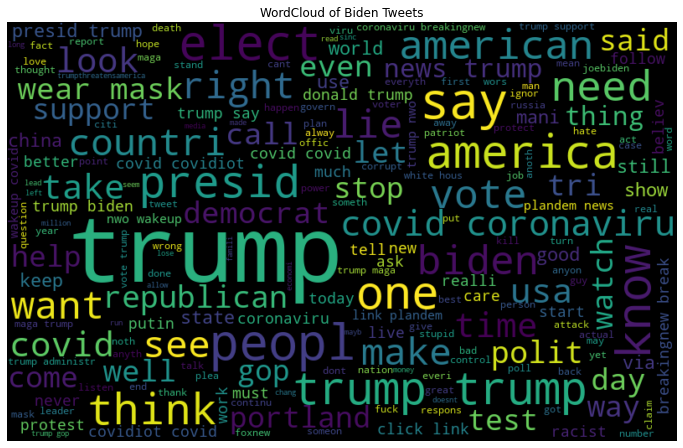

In [67]:
plt.figure(figsize = (12, 12), facecolor="None") 
plt.imshow(wordcloud,interpolation='bilinear') 
plt.axis("off") 
plt.title("WordCloud of Biden Tweets")
plt.show()

Word clouds, created by words corresponding to maximum frequency within the twitter data stream help in identifying keywords and trends.

# Sentiment Analysis

In [68]:
from textblob import TextBlob

In [69]:
pol=[]
for Tweet in all_words:
    blob = TextBlob(Tweet)
    pol.append(blob.sentiment.polarity)

In [70]:

len(pol)

15654

In [71]:
len(text)

233432

In [72]:
df['Processed_Tweet']

0        [amaz, hope, get, support, need, resist, trump...
1        [trump, final, admit, spread, coronaviru, get,...
2        [sure, sign, gop, parti, break, apart, start, ...
3        [trump, silent, cop, beat, veteran, put, hospi...
4        [speak, fall, pleas, care, climb, chairthos, p...
                               ...                        
15649    [far, easier, remain, self, delus, seek, delud...
15650    [actual, thought, trump, undamag, brain, cell,...
15651    [attempt, assassin, son, kill, obama, nomin, f...
15652    [lose, respect, foxnew, peopl, like, chriswall...
15653    [fli, flag, half, staff, dont, think, racist, ...
Name: Processed_Tweet, Length: 15654, dtype: object

In [73]:

positive=0
negative=0
neutral=0
for i in pol:
    if i>0:
        positive+=1
    elif i<0:
        negative+=1
    else:
        neutral+=1
print("Positive Tweets:",positive)
print("Negative Tweets:",negative)
print("Neutral Tweets",neutral)

Positive Tweets: 5325
Negative Tweets: 3701
Neutral Tweets 6628


In [74]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [75]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
sentiment_scores= []
for i in all_words:
    sentiment_scores.append([sid.polarity_scores(i)])
#sentimental_score = pd.DataFrame(list(sentiment_scores))
#sentimental_score.tail(12)

In [76]:
value = []
for i in sentiment_scores:
    for dict1 in i:
        value.append(list(dict1.values()))

In [77]:

sentimental_score_df = pd.DataFrame(data = value, columns = ['Negative','Neutral','Positive','Compound'])
sentimental_score_df

,Negative,Neutral,Positive,Compound
0,0.000,0.641,0.359,0.6808
1,0.000,0.699,0.301,0.7096
2,0.168,0.721,0.111,-0.2960
3,0.101,0.754,0.146,0.2263
4,0.000,0.833,0.167,0.4939
...,...,...,...,...
15649,0.134,0.649,0.216,0.2263
15650,0.124,0.876,0.000,-0.4767
15651,0.245,0.755,0.000,-0.7783
15652,0.225,0.542,0.233,0.0516


In [78]:
sentimental_score_df['val'] = sentimental_score_df['Compound'].apply(lambda x: 'Neutral' if x == 0 else ('Positive' if x > 0 else 'Negative'))
sentimental_score_df.head()

,Negative,Neutral,Positive,Compound,val
0,0.000,0.641,0.359,0.6808,Positive
1,0.000,0.699,0.301,0.7096,Positive
2,0.168,0.721,0.111,-0.2960,Negative
3,0.101,0.754,0.146,0.2263,Positive
4,0.000,0.833,0.167,0.4939,Positive


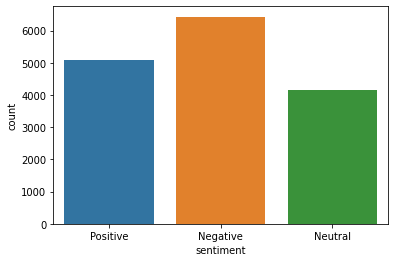

In [79]:
sent_count = pd.DataFrame.from_dict(Counter(sentimental_score_df['val']), orient = 'index').reset_index()
sent_count.columns = ['sentiment', 'count']

sns.barplot(y="count", x='sentiment', data=sent_count)

In [81]:
filepath = r"/content/drive/MyDrive/Projects/Twitter_Sentiment_Analysis_US_Presedential_Elction2020/NRC Emotion Lexicon.txt"
emolex_df = pd.read_csv(filepath,  names=["word", "emotion", "association"], skiprows=45, sep='\t')
emolex_df.head(12)
len(emolex_df)

86343

In [82]:

emotions={'positive':0, 'negative':0, 'surprise':0,'sadness':0,
          'anger':0,'joy':0,'negative':0,'trust':0,'fear':0,'anticipation':0,'disgust':0}

In [83]:
word_emotion=dict()
for i in range(0,86343):
    emotion=emolex_df['emotion'][i]
    word=emolex_df['word'][i]
    association=emolex_df['association'][i]
    
    if word not in word_emotion:
        word_emotion[word]=dict()
    word_emotion[word][emotion]=association

In [84]:
for i in range(0,15654):
    text=df['Tweet'][i]
    for j in text.split():
        if j in word_emotion:
            for k in word_emotion[j]:
                emotions[k]+=word_emotion[j][k]

In [85]:
emotions

{'positive': 5975.0,
 'negative': 7216.0,
 'surprise': 1774.0,
 'sadness': 3303.0,
 'anger': 3849.0,
 'joy': 2154.0,
 'trust': 3807.0,
 'fear': 4253.0,
 'anticipation': 2561.0,
 'disgust': 2516.0}

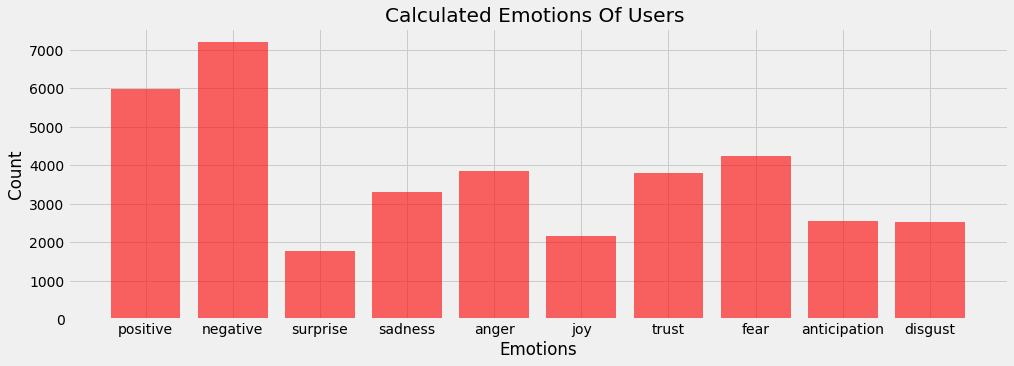

In [86]:

plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = [15,5]
plt.bar(list(emotions.keys()),list(emotions.values()),color='red',alpha = 0.6)
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.title('Calculated Emotions Of Users ')
plt.show()

In [87]:
df.Location  = df.Location.fillna('USA')

In [88]:

f = [i for i in df['Location'] if type(i) != str]
f

[]

In [89]:
df.Location = df.Location.apply(lambda x: x.replace('United States','USA'))

In [90]:

df.Location.value_counts()

USA                         5055
California, USA              353
Washington, DC               261
Florida, USA                 116
New York, NY                 107
                            ... 
Country adjacent to CHAZ       1
Pittsburgh Pennsylvania        1
Montreal, Quebec, CANADA       1
Chicago.                       1
Chicagoland, IL                1
Name: Location, Length: 3316, dtype: int64

In [91]:

locations = []
locations_1 = []

locations = [i.split(',')[-1] for i in df['Location']]
locations_1 =  [i.split(',')[0] for i in df['Location']]
df['Processed_Location'] = locations_1
df

,Date,Tweet_id,Verified,Tweet,User,Location,Source,Likes,Followers,Following,Retweets,Processed_Tweet,Processed_Location
0,2020-07-21 23:59:54,1285726226813014016,False,"You are amazing, @chicagosmayor. I hope you g...",rathacat,"Patterson, CA",Twitter Web App,1,2429,3710,0,"[amaz, hope, get, support, need, resist, trump...",Patterson
1,2020-07-21 23:59:51,1285726213001093127,False,#Trump finally admitted that the spread of the...,Nor_Kan_1965,USA,Twitter for Android,1,112,73,1,"[trump, final, admit, spread, coronaviru, get,...",USA
2,2020-07-21 23:59:30,1285726126820794368,False,@NavygirlLaura @GOP A sure sign the #GOP party...,ShannsolSolberg,"Texas, USA",Twitter for iPhone,1,1359,1745,0,"[sure, sign, gop, parti, break, apart, start, ...",Texas
3,2020-07-21 23:59:20,1285726083455877121,False,Why is #Trump silent when cops beat a #Veteran...,in_pubs,NJ-DC-NY-🌍,Twitter for iPhone,650,78851,17726,254,"[trump, silent, cop, beat, veteran, put, hospi...",NJ-DC-NY-🌍
4,2020-07-21 23:58:51,1285725963024818183,False,"@gtconway3d Speaking of falling, please be car...",dfwcitizen,• GOD BLESS AMERICA •,Twitter for iPhone,2,5333,375,0,"[speak, fall, pleas, care, climb, chairthos, p...",• GOD BLESS AMERICA •
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15649,2020-07-20 13:13:27,1285201151894392833,False,"""It’s far easier to remain in self-delusion an...",ingatweet,"Connecticut, USA",Twitter for Android,0,179,389,0,"[far, easier, remain, self, delus, seek, delud...",Connecticut
15650,2020-07-20 13:13:22,1285201132340510728,False,If you actually thought that #Trump had undama...,Tonypapa9,Milky Way,Twitter Web App,4,16498,15778,0,"[actual, thought, trump, undamag, brain, cell,...",Milky Way
15651,2020-07-20 13:13:19,1285201118398685190,False,Attempted assassination (son killed) of NJ #Ob...,robertropars,"Chicagoland, IL",Twitter for Android,2,6953,5537,2,"[attempt, assassin, son, kill, obama, nomin, f...",Chicagoland
15652,2020-07-20 13:13:17,1285201111469756416,False,Losing respect for #FoxNews people like #Chris...,onemorevoice7,USA,Twitter for iPhone,1,699,718,0,"[lose, respect, foxnew, peopl, like, chriswall...",USA


In [92]:
df1 = df

In [93]:
df1['sentiment'] = sentimental_score_df['val']



In [94]:
df1.head()

,Date,Tweet_id,Verified,Tweet,User,Location,Source,Likes,Followers,Following,Retweets,Processed_Tweet,Processed_Location,sentiment
0,2020-07-21 23:59:54,1285726226813014016,False,"You are amazing, @chicagosmayor. I hope you g...",rathacat,"Patterson, CA",Twitter Web App,1,2429,3710,0,"[amaz, hope, get, support, need, resist, trump...",Patterson,Positive
1,2020-07-21 23:59:51,1285726213001093127,False,#Trump finally admitted that the spread of the...,Nor_Kan_1965,USA,Twitter for Android,1,112,73,1,"[trump, final, admit, spread, coronaviru, get,...",USA,Positive
2,2020-07-21 23:59:30,1285726126820794368,False,@NavygirlLaura @GOP A sure sign the #GOP party...,ShannsolSolberg,"Texas, USA",Twitter for iPhone,1,1359,1745,0,"[sure, sign, gop, parti, break, apart, start, ...",Texas,Negative
3,2020-07-21 23:59:20,1285726083455877121,False,Why is #Trump silent when cops beat a #Veteran...,in_pubs,NJ-DC-NY-🌍,Twitter for iPhone,650,78851,17726,254,"[trump, silent, cop, beat, veteran, put, hospi...",NJ-DC-NY-🌍,Positive
4,2020-07-21 23:58:51,1285725963024818183,False,"@gtconway3d Speaking of falling, please be car...",dfwcitizen,• GOD BLESS AMERICA •,Twitter for iPhone,2,5333,375,0,"[speak, fall, pleas, care, climb, chairthos, p...",• GOD BLESS AMERICA •,Positive


In [95]:

df1.to_csv('Location.csv',index = False)

In [96]:

df1['day'] = df.Date.dt.day
df1.head()

,Date,Tweet_id,Verified,Tweet,User,Location,Source,Likes,Followers,Following,Retweets,Processed_Tweet,Processed_Location,sentiment,day
0,2020-07-21 23:59:54,1285726226813014016,False,"You are amazing, @chicagosmayor. I hope you g...",rathacat,"Patterson, CA",Twitter Web App,1,2429,3710,0,"[amaz, hope, get, support, need, resist, trump...",Patterson,Positive,21
1,2020-07-21 23:59:51,1285726213001093127,False,#Trump finally admitted that the spread of the...,Nor_Kan_1965,USA,Twitter for Android,1,112,73,1,"[trump, final, admit, spread, coronaviru, get,...",USA,Positive,21
2,2020-07-21 23:59:30,1285726126820794368,False,@NavygirlLaura @GOP A sure sign the #GOP party...,ShannsolSolberg,"Texas, USA",Twitter for iPhone,1,1359,1745,0,"[sure, sign, gop, parti, break, apart, start, ...",Texas,Negative,21
3,2020-07-21 23:59:20,1285726083455877121,False,Why is #Trump silent when cops beat a #Veteran...,in_pubs,NJ-DC-NY-🌍,Twitter for iPhone,650,78851,17726,254,"[trump, silent, cop, beat, veteran, put, hospi...",NJ-DC-NY-🌍,Positive,21
4,2020-07-21 23:58:51,1285725963024818183,False,"@gtconway3d Speaking of falling, please be car...",dfwcitizen,• GOD BLESS AMERICA •,Twitter for iPhone,2,5333,375,0,"[speak, fall, pleas, care, climb, chairthos, p...",• GOD BLESS AMERICA •,Positive,21


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


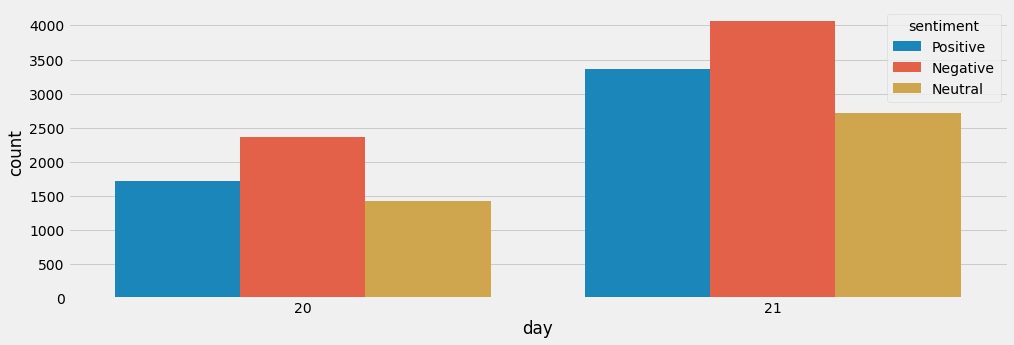

In [97]:
sns.countplot(df['day'],hue = df['sentiment'])

In [98]:
df1.to_excel("output.xlsx") 

In [99]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [100]:
le = LabelEncoder()  


In [101]:
df1['sentiment'] = df1['sentiment'] .astype(str)

In [102]:
df1['sentiment_1']= le.fit_transform(df1['sentiment'])

In [103]:
Df2 = df1.query('sentiment_1 != 3')

In [104]:
df1

,Date,Tweet_id,Verified,Tweet,User,Location,Source,Likes,Followers,Following,Retweets,Processed_Tweet,Processed_Location,sentiment,day,sentiment_1
0,2020-07-21 23:59:54,1285726226813014016,False,"You are amazing, @chicagosmayor. I hope you g...",rathacat,"Patterson, CA",Twitter Web App,1,2429,3710,0,"[amaz, hope, get, support, need, resist, trump...",Patterson,Positive,21,2
1,2020-07-21 23:59:51,1285726213001093127,False,#Trump finally admitted that the spread of the...,Nor_Kan_1965,USA,Twitter for Android,1,112,73,1,"[trump, final, admit, spread, coronaviru, get,...",USA,Positive,21,2
2,2020-07-21 23:59:30,1285726126820794368,False,@NavygirlLaura @GOP A sure sign the #GOP party...,ShannsolSolberg,"Texas, USA",Twitter for iPhone,1,1359,1745,0,"[sure, sign, gop, parti, break, apart, start, ...",Texas,Negative,21,0
3,2020-07-21 23:59:20,1285726083455877121,False,Why is #Trump silent when cops beat a #Veteran...,in_pubs,NJ-DC-NY-🌍,Twitter for iPhone,650,78851,17726,254,"[trump, silent, cop, beat, veteran, put, hospi...",NJ-DC-NY-🌍,Positive,21,2
4,2020-07-21 23:58:51,1285725963024818183,False,"@gtconway3d Speaking of falling, please be car...",dfwcitizen,• GOD BLESS AMERICA •,Twitter for iPhone,2,5333,375,0,"[speak, fall, pleas, care, climb, chairthos, p...",• GOD BLESS AMERICA •,Positive,21,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15649,2020-07-20 13:13:27,1285201151894392833,False,"""It’s far easier to remain in self-delusion an...",ingatweet,"Connecticut, USA",Twitter for Android,0,179,389,0,"[far, easier, remain, self, delus, seek, delud...",Connecticut,Positive,20,2
15650,2020-07-20 13:13:22,1285201132340510728,False,If you actually thought that #Trump had undama...,Tonypapa9,Milky Way,Twitter Web App,4,16498,15778,0,"[actual, thought, trump, undamag, brain, cell,...",Milky Way,Negative,20,0
15651,2020-07-20 13:13:19,1285201118398685190,False,Attempted assassination (son killed) of NJ #Ob...,robertropars,"Chicagoland, IL",Twitter for Android,2,6953,5537,2,"[attempt, assassin, son, kill, obama, nomin, f...",Chicagoland,Negative,20,0
15652,2020-07-20 13:13:17,1285201111469756416,False,Losing respect for #FoxNews people like #Chris...,onemorevoice7,USA,Twitter for iPhone,1,699,718,0,"[lose, respect, foxnew, peopl, like, chriswall...",USA,Positive,20,2


In [105]:
df1.sentiment.isnull().sum()

0

In [106]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Defining the vectorizer 
vect = TfidfVectorizer(ngram_range=(1,1), max_features=1500).fit(all_words)

# Transform the vectorizer
X_tfidf = vect.transform(all_words).toarray()
y = df1['sentiment_1']

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size = 0.3, random_state = 0)

##Decision Tree

In [108]:

classifier_DT = DecisionTreeClassifier()
classifier_DT.fit(X_train, y_train)
y_pred_DT = classifier_DT.predict(X_test)

In [109]:
accuracy_score_DT = accuracy_score(y_test, y_pred_DT)
precision_score_DT = precision_score(y_test, y_pred_DT , average = 'micro')
recall_score_DT = recall_score(y_test, y_pred_DT , average = 'micro')
f1_score_DT = f1_score(y_test, y_pred_DT , average = 'micro')
print("Accuracy Score: " , accuracy_score_DT)
print("Precision Score: " , precision_score_DT)
print("Recall Score: " , recall_score_DT)
print("F1 Score: " , f1_score_DT)

Accuracy Score:  0.7234404939322973
Precision Score:  0.7234404939322973
Recall Score:  0.7234404939322973
F1 Score:  0.7234404939322973


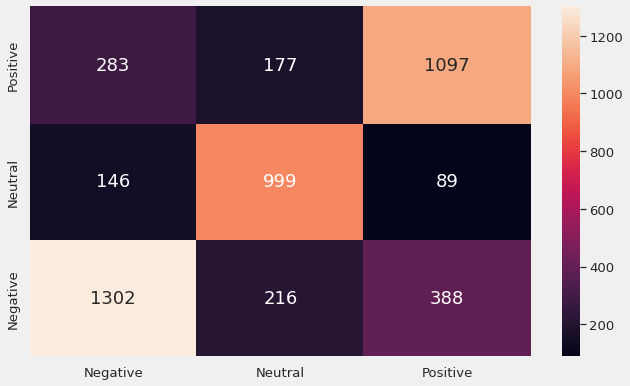

In [110]:
cm_DT = confusion_matrix(y_test, y_pred_DT)

      # neg # neutr  # pos
# pos #  232   65      1397
# neu #  87   1175     51
# neg # 1104   82      321

df_cm_DT = pd.DataFrame(cm_DT, range(3), range(3))
plt.figure(figsize=(10,6))
categories = ['Negative','Neutral','Positive']
sns.set(font_scale=1.2) # for label size
sns.heatmap(df_cm_DT, annot=True, annot_kws={"size": 18}, xticklabels = categories,
            yticklabels = categories ,fmt="d") # font size
plt.ylim(0, 3)
plt.show()

## Hyperparameter Tuning For Decision Trees

In [111]:
#Getting the parameters of the particular model 
classifier_DT.get_params().keys()

dict_keys(['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])

In [112]:
classifier_DT_opti = DecisionTreeClassifier() 

param_grid = {"max_depth" : [1,3,5,7],     #Setting the parameters for the model
               "criterion" : ["gini","entropy"],
              "min_samples_split" : [2,3,4],
              "max_leaf_nodes" : [7,8,9],
              "min_samples_leaf": [2,3,4],
             }

In [113]:
model_DT = model_selection.GridSearchCV(estimator=classifier_DT_opti, #GridSearch
                                    param_grid=param_grid, 
                                        cv=10)
model_DT.fit(X_train,y_train)
print(model_DT.best_score_) #Gives the best score of the model
print(model_DT.best_estimator_.get_params()) #Gives the best parameters

0.4913779455387795
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 7, 'max_features': None, 'max_leaf_nodes': 9, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


In [114]:
y_pred_model_DT = model_DT.predict(X_test)

accuracy_score_model_DT = accuracy_score(y_test, y_pred_model_DT)
precision_score_model_DT = precision_score(y_test, y_pred_model_DT , average = 'micro')
recall_score_model_DT = recall_score(y_test, y_pred_model_DT , average = 'micro')
f1_score_model_DT = f1_score(y_test, y_pred_model_DT , average = 'micro')
print("Accuracy Score: " , accuracy_score_model_DT)
print("Precision Score: " , precision_score_model_DT)
print("Recall Score: " , recall_score_model_DT)
print("F1 Score: " , f1_score_model_DT)

Accuracy Score:  0.48818394720034064
Precision Score:  0.48818394720034064
Recall Score:  0.48818394720034064
F1 Score:  0.48818394720034064


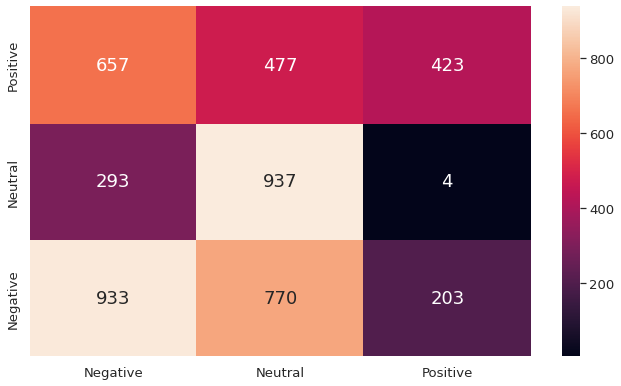

In [115]:
cm_model_DT = confusion_matrix(y_test, y_pred_model_DT)

      # neg # neutr  # pos
# pos #  0    920      774
# neu #  0   1311       2
# neg #  7    1210     290

df_cm_model_DT = pd.DataFrame(cm_model_DT, range(3), range(3))
plt.figure(figsize=(10,6))
categories = ['Negative','Neutral','Positive']
sns.set(font_scale=1.2) # for label size
sns.heatmap(df_cm_model_DT, annot=True, annot_kws={"size": 18}, xticklabels = categories,
            yticklabels = categories ,fmt="d") # font size
plt.ylim(0, 3)
plt.show()

##Random Forest

In [116]:
classifier_RF = RandomForestClassifier()
classifier_RF.fit(X_train, y_train)
y_pred_RF = classifier_RF.predict(X_test)

In [117]:
accuracy_score_RF = accuracy_score(y_test, y_pred_RF)
precision_score_RF = precision_score(y_test, y_pred_RF , average = 'micro')
recall_score_RF = recall_score(y_test, y_pred_RF, average = 'micro')
f1_score_RF = f1_score(y_test, y_pred_RF, average = 'micro')
print("Accuracy Score: " , accuracy_score_RF)
print("Precision Score: " , precision_score_RF)
print("Recall Score: " , recall_score_RF)
print("F1 Score: " , f1_score_RF)

Accuracy Score:  0.8109431552054502
Precision Score:  0.8109431552054502
Recall Score:  0.8109431552054502
F1 Score:  0.8109431552054502


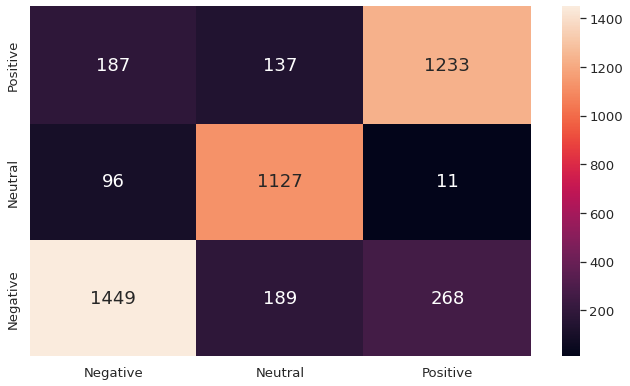

In [118]:
cm_RF = confusion_matrix(y_test, y_pred_RF)

      # neg # neutr  # pos
# pos # 198    92     1404
# neu #  53   1233      27
# neg # 1120   121     266

df_cm_RF = pd.DataFrame(cm_RF, range(3), range(3))
categories = ['Negative','Neutral','Positive']
plt.figure(figsize=(10,6))
sns.set(font_scale=1.2) # for label size
sns.heatmap(df_cm_RF, annot=True, annot_kws={"size": 18}, xticklabels = categories,
            yticklabels = categories,fmt="d") # font size
plt.ylim(0, 3)
plt.show()

## Hyperparameter Tuning For Random Forest

In [119]:
#Getting the parameters of the particular model 
classifier_RF.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [120]:
classifier_RF_opti = RandomForestClassifier()
param_grid = {"n_estimators": np.arange(100,1500,100), #Selecting the parameters
               "max_depth": np.arange(1,20),
               "criterion": ["gini","entropy"], 
              }

In [121]:
classifier_model_RF = model_selection.RandomizedSearchCV(estimator=classifier_RF_opti, #RandomizedSearch
                                    param_distributions=param_grid,
                                    n_iter=10,
                                    scoring='accuracy',
                                    verbose=10,
                                    n_jobs=1,
                                    cv=5)

classifier_model_RF.fit(X_train,y_train)
print(classifier_model_RF.best_score_) #Gives the best score of the model
print(classifier_model_RF.best_estimator_.get_params()) #Gives the best parameters of the model

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START criterion=entropy, max_depth=5, n_estimators=100...........
[CV 1/5; 1/10] END criterion=entropy, max_depth=5, n_estimators=100;, score=0.454 total time=   1.0s
[CV 2/5; 1/10] START criterion=entropy, max_depth=5, n_estimators=100...........
[CV 2/5; 1/10] END criterion=entropy, max_depth=5, n_estimators=100;, score=0.459 total time=   1.0s
[CV 3/5; 1/10] START criterion=entropy, max_depth=5, n_estimators=100...........
[CV 3/5; 1/10] END criterion=entropy, max_depth=5, n_estimators=100;, score=0.451 total time=   1.1s
[CV 4/5; 1/10] START criterion=entropy, max_depth=5, n_estimators=100...........
[CV 4/5; 1/10] END criterion=entropy, max_depth=5, n_estimators=100;, score=0.463 total time=   1.0s
[CV 5/5; 1/10] START criterion=entropy, max_depth=5, n_estimators=100...........
[CV 5/5; 1/10] END criterion=entropy, max_depth=5, n_estimators=100;, score=0.456 total time=   1.0s
[CV 1/5; 2/10] START criterio

In [122]:
y_pred_model_RF = classifier_model_RF.predict(X_test)

accuracy_score_model_RF = accuracy_score(y_test, y_pred_model_RF)
precision_score_model_RF = precision_score(y_test, y_pred_model_RF , average = 'micro')
recall_score_model_RF = recall_score(y_test, y_pred_model_RF , average = 'micro')
f1_score_model_RF = f1_score(y_test, y_pred_model_RF , average = 'micro')
print("Accuracy Score: " , accuracy_score_model_RF)
print("Precision Score: " , precision_score_model_RF)
print("Recall Score: " , recall_score_model_RF)
print("F1 Score: " , f1_score_model_RF)

Accuracy Score:  0.6953374494358101
Precision Score:  0.6953374494358101
Recall Score:  0.6953374494358101
F1 Score:  0.6953374494358101


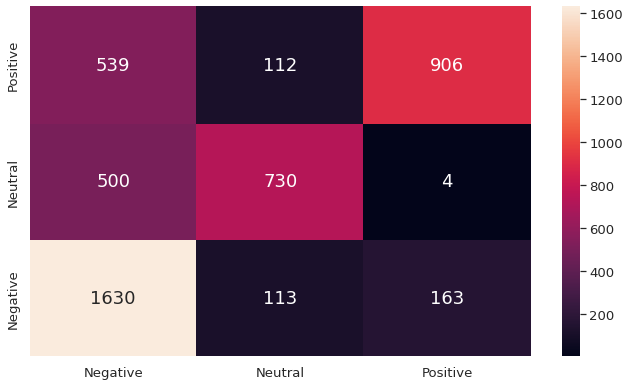

In [123]:
cm_model_RF = confusion_matrix(y_test, y_pred_model_RF)

      # neg # neutr  # pos
# pos #  89    246     1359
# neu #  43   1253     17
# neg #  917   292     298

df_cm_model_RF = pd.DataFrame(cm_model_RF, range(3), range(3))
plt.figure(figsize=(10,6))
categories = ['Negative','Neutral','Positive']
sns.set(font_scale=1.2) # for label size
sns.heatmap(df_cm_model_RF, annot=True, annot_kws={"size": 18}, xticklabels = categories,
            yticklabels = categories ,fmt="d") # font size
plt.ylim(0, 3)
plt.show()

## Naive Bayes

In [124]:
classifier_NB = MultinomialNB()
classifier_NB.fit(X_train, y_train)
y_pred_NB = classifier_NB.predict(X_test)

In [125]:
accuracy_score_NB = accuracy_score(y_test, y_pred_NB)
precision_score_NB = precision_score(y_test, y_pred_NB , average = 'micro')
recall_score_NB = recall_score(y_test, y_pred_NB, average = 'micro')
f1_score_NB = f1_score(y_test, y_pred_NB, average = 'micro')
print("Accuracy Score: " , accuracy_score_NB)
print("Precision Score: " , precision_score_NB)
print("Recall Score: " , recall_score_NB)
print("F1 Score: " , f1_score_NB)

Accuracy Score:  0.6853310623802427
Precision Score:  0.6853310623802427
Recall Score:  0.6853310623802427
F1 Score:  0.6853310623802427


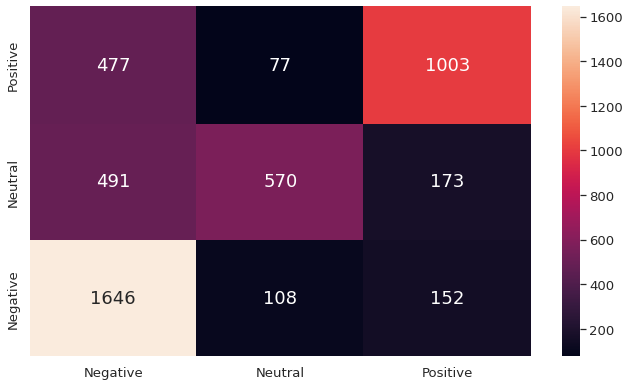

In [126]:
cm_NB = confusion_matrix(y_test, y_pred_NB)

      # neg # neutr  # pos
# pos # 202    133     1359
# neu # 137   931      245
# neg # 1076  160      271

df_cm_NB = pd.DataFrame(cm_NB, range(3), range(3))
plt.figure(figsize=(10,6))
categories = ['Negative','Neutral','Positive']
sns.set(font_scale=1.2) # for label size
sns.heatmap(df_cm_NB, annot=True, annot_kws={"size": 18}, xticklabels = categories,
            yticklabels = categories,fmt="d") # font size
plt.ylim(0, 3)
plt.show()

## Hyperparameter Tuning For Naive Bayes

In [127]:
#Getting the parameters of the particular model 
classifier_NB.get_params().keys()

dict_keys(['alpha', 'class_prior', 'fit_prior'])

In [128]:
classifier_NB_opti = MultinomialNB() #Using the MultinomialNB
param_grid = {'alpha':[1,2,3,4], } #Selecting the parameters

In [129]:
classifier_model_NB = model_selection.GridSearchCV(estimator=classifier_NB_opti, #GridSearch
                                    param_grid=param_grid,
                                        cv=10)
classifier_model_NB.fit(X_train,y_train)
print(classifier_model_NB.best_score_) #Gives the best score of the model
print(classifier_model_NB.best_estimator_.get_params()) #Gives the best parameters of the model

0.6920696263706961
{'alpha': 1, 'class_prior': None, 'fit_prior': True}


In [130]:
y_pred_model_NB = classifier_model_NB.predict(X_test)

accuracy_score_model_NB = accuracy_score(y_test, y_pred_model_NB)
precision_score_model_NB = precision_score(y_test, y_pred_model_NB , average = 'micro')
recall_score_model_NB = recall_score(y_test, y_pred_model_NB , average = 'micro')
f1_score_model_NB = f1_score(y_test, y_pred_model_NB, average = 'micro')
print("Accuracy Score: " , accuracy_score_model_NB)
print("Precision Score: " , precision_score_model_NB)
print("Recall Score: " , recall_score_model_NB)
print("F1 Score: " , f1_score_model_NB)

Accuracy Score:  0.6853310623802427
Precision Score:  0.6853310623802427
Recall Score:  0.6853310623802427
F1 Score:  0.6853310623802427


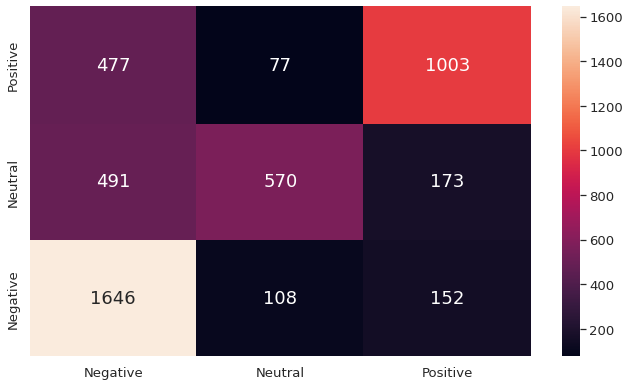

In [131]:
cm_model_NB = confusion_matrix(y_test, y_pred_model_NB)

      # neg # neutr  # pos
# pos #  202   133     1359
# neu #  137   931     245
# neg #  1076  160     271

df_cm_model_NB = pd.DataFrame(cm_model_NB, range(3), range(3))
plt.figure(figsize=(10,6))
categories = ['Negative','Neutral','Positive']
sns.set(font_scale=1.2) # for label size
sns.heatmap(df_cm_model_NB, annot=True, annot_kws={"size": 18}, xticklabels = categories,
            yticklabels = categories ,fmt="d") # font size
plt.ylim(0, 3)
plt.show()

## Comparing Models

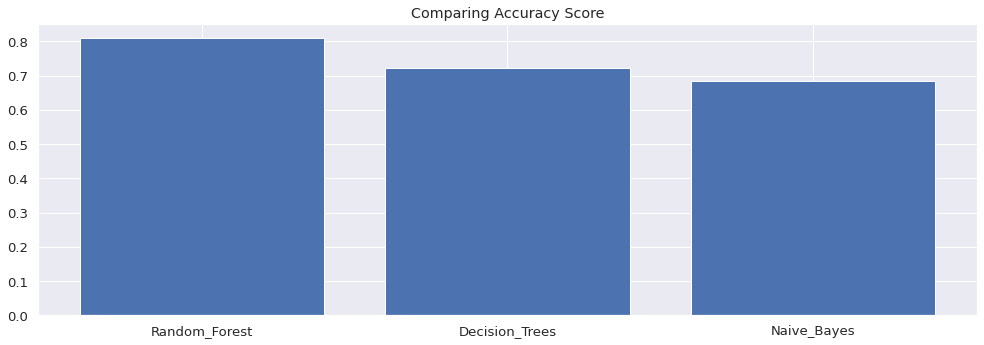

In [132]:
Accuracy = [accuracy_score_RF, accuracy_score_DT, accuracy_score_model_NB]
Methods = ['Random_Forest', 'Decision_Trees', 'Naive_Bayes']
Accuracy_pos = np.arange(len(Methods))
plt.bar(Accuracy_pos, Accuracy)
plt.xticks(Accuracy_pos, Methods)
plt.title('Comparing Accuracy Score')
plt.show()

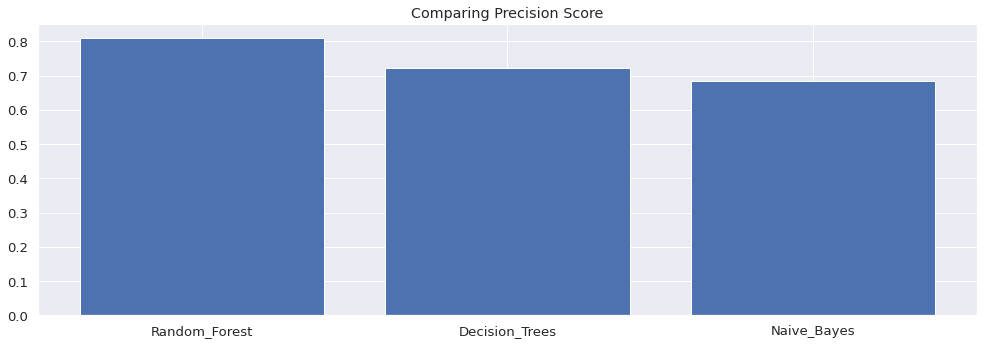

In [133]:
Precision = [precision_score_RF, precision_score_DT, precision_score_model_NB]
Methods = ['Random_Forest', 'Decision_Trees', 'Naive_Bayes']
Precision_pos = np.arange(len(Methods))
plt.bar(Precision_pos, Precision)
plt.xticks(Precision_pos, Methods)
plt.title('Comparing Precision Score')
plt.show()

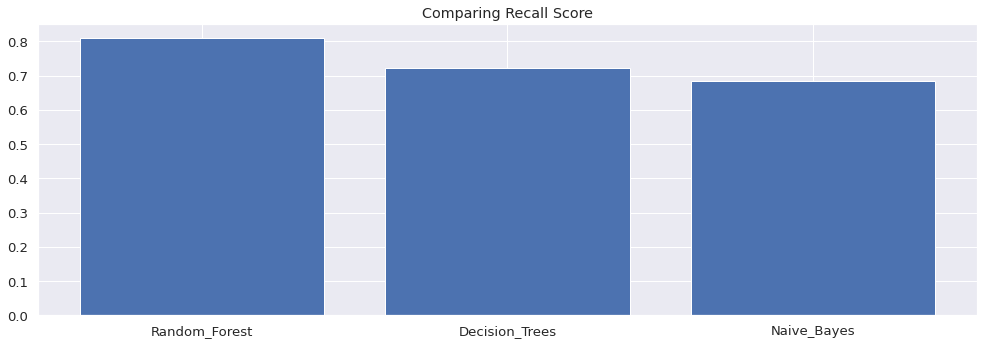

In [134]:
Recall = [recall_score_RF, recall_score_DT, recall_score_model_NB]
Methods = ['Random_Forest', 'Decision_Trees', 'Naive_Bayes']
Recall_pos = np.arange(len(Methods))
plt.bar(Recall_pos, Recall)
plt.xticks(Recall_pos, Methods)
plt.title('Comparing Recall Score')
plt.show()

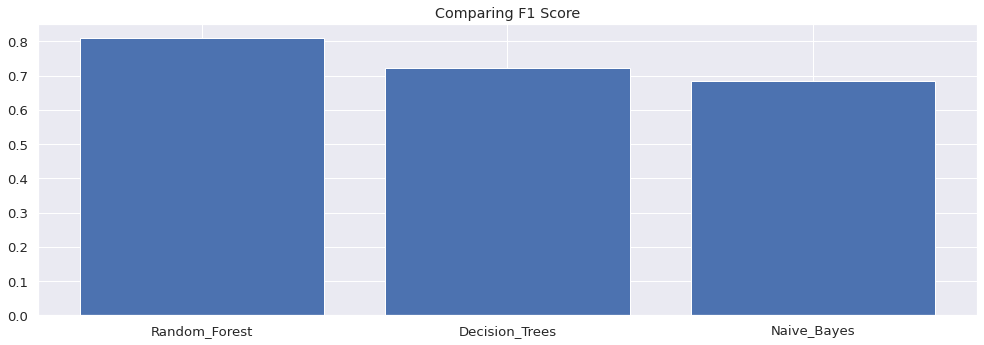

In [135]:
F1 = [f1_score_RF,f1_score_DT,f1_score_model_NB]
Methods = ['Random_Forest', 'Decision_Trees', 'Naive_Bayes']
F1_pos = np.arange(len(Methods))
plt.bar(F1_pos, F1)
plt.xticks(F1_pos, Methods)
plt.title('Comparing F1 Score')
plt.show()

It's evident that Random_Forest is workig the best among the three models used.